# Saliency

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
import time
import pickle
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
#from pandarallel import pandarallel
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.main import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)
%matplotlib inline

In [4]:
# load et data
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'

# DeepGazeII
df_wk0 = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_dg.csv')) 
df_ff0 = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_dg.csv'))
df_tp0 = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_dg.csv'))

# ViNet
df_wk1 = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_vn.csv')) 
df_ff1 = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_vn.csv'))
df_tp1 = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_vn.csv'))

# FineGrained
df_wk2 = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_finegrained.csv')) 
df_ff2 = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_finegrained.csv'))
df_tp2 = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_finegrained.csv'))

# Spectral
df_wk3 = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_spectral.csv')) 
df_ff3 = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_spectral.csv'))
df_tp3 = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_spectral.csv'))

# load video data
videos_data = load_video_data()
trials_data = load_trials_data()

In [5]:
df_wk0.shape, df_wk1.shape, df_wk2.shape, df_wk3.shape

((363788, 9), (363788, 9), (363788, 9), (363788, 9))

In [6]:
df_tp0.shape, df_tp1.shape, df_tp2.shape, df_tp3.shape

((154614, 9), (154614, 9), (154614, 9), (154614, 9))

In [7]:
df_ff0.shape, df_ff1.shape, df_ff2.shape, df_ff3.shape

((88877, 9), (88877, 9), (88877, 9), (88877, 9))

## Merging NSS values and saving

In [8]:
dfs_wk = [df_wk1[['NSS']].rename(columns={'NSS':'NSS_vn'}), df_wk2[['NSS']].rename(columns={'NSS':'NSS_fg'}), df_wk3[['NSS']].rename(columns={'NSS':'NSS_sp'})]
df_wk  = df_wk0.join(dfs_wk, how='outer').rename(columns={'NSS':'NSS_dg'}).drop(columns=['FLAG','NSS_MEAN'])

In [9]:
dfs_tp = [df_tp1[['NSS']].rename(columns={'NSS':'NSS_vn'}), df_tp2[['NSS']].rename(columns={'NSS':'NSS_fg'}), df_tp3[['NSS']].rename(columns={'NSS':'NSS_sp'})]
df_tp  = df_tp0.join(dfs_tp, how='outer').rename(columns={'NSS':'NSS_dg'}).drop(columns=['FLAG','NSS_MEAN'])

In [10]:
dfs_ff = [df_ff1[['NSS']].rename(columns={'NSS':'NSS_vn'}), df_ff2[['NSS']].rename(columns={'NSS':'NSS_fg'}), df_ff3[['NSS']].rename(columns={'NSS':'NSS_sp'})]
df_ff  = df_ff0.join(dfs_ff, how='outer').rename(columns={'NSS':'NSS_dg'}).drop(columns=['FLAG','NSS_MEAN'])

In [11]:
df_tp.head()

,ID,FIX_idx,NSS_dg,FIX_IN_VID,VIDEO_NAME,ET_FILE,FRAME_idx,NSS_vn,NSS_fg,NSS_sp
0,NDARVB819ENX,1,-0.955203,527,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2,-0.541173,-0.157572,-0.256113
1,NDARVB819ENX,4,-0.018449,527,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,11,-0.333929,-0.241018,-0.249567
2,NDARVB819ENX,6,-0.354813,527,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,14,-0.451831,-0.266116,-0.264252
3,NDARVB819ENX,8,-0.342154,527,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17,-0.471047,-0.275079,-0.255580
4,NDARVB819ENX,10,6.080756,527,Present,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,22,5.106561,5.086951,1.654087


In [12]:
df_wk.shape, df_tp.shape, df_ff.shape

((363788, 10), (154614, 10), (88877, 10))

In [13]:
# Add mean dg, vn
# Add fix_x, fix_y, ts
def add_new_columns(df, vid_name, data_path, trials_data, videos_data):
    dfs_list = []
    for idx in df.ID.unique():
    
        df_aux       = df[df.ID==idx].copy()
        et_file      = df_aux.ET_FILE.iloc[0]
        df_et        = pd.read_csv(os.path.join(data_path,et_file[2:]))
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        trial_init   = trials_data.loc[idx].set_index('VideoName').loc[vid_name].Start
        df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
        new_cols     = df_fix[['x_mean', 'y_mean','start_time']].copy()
        #print(df_fix.columns)
        #print(df_fix.index)
        #break
        df_aux       = df_aux.merge(new_cols,how='right',left_on='FIX_idx',right_index=True)    
        dfs_list.append(df_aux)
        
    df_exploded_frames = pd.concat(dfs_list)
    #df_exploded_frames.rename({'frames_seen':'FRAME_idx'}, axis=1, inplace=True)
    
    return df_exploded_frames

In [14]:
df_wk = add_new_columns(df_wk, 'Diary', '', trials_data, videos_data)
df_tp = add_new_columns(df_tp, 'Present', '', trials_data, videos_data)
df_ff = add_new_columns(df_ff, 'Fractals', '', trials_data, videos_data)

In [15]:
df_wk.head()

,ID,FIX_idx,NSS_dg,FIX_IN_VID,VIDEO_NAME,ET_FILE,FRAME_idx,NSS_vn,NSS_fg,NSS_sp,x_mean,y_mean,start_time
0,NDARJH925ZCD,5,-0.293100,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,7,-0.100497,-0.396219,-0.414514,582.297273,440.065455,254.453
1,NDARJH925ZCD,7,0.255356,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,11,2.227505,0.889796,0.644614,470.131429,294.679286,454.385
2,NDARJH925ZCD,9,6.999779,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17,2.251315,2.175435,2.470116,350.885000,294.072500,704.298
3,NDARJH925ZCD,11,2.229405,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,25,0.279915,0.435105,1.370525,278.265000,303.217500,1020.824
4,NDARJH925ZCD,13,0.908096,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,33,0.052687,1.367706,0.067163,263.296000,299.036000,1337.382


In [16]:
#df_wk_all_sal['NSS_vn_mean'] = df_wk_all_sal[['ID', 'NSS_vn']].groupby(df_wk_all_sal['ID']).transform('mean')

In [17]:
df_wk.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_wk_full.csv'), index=False)
df_tp.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_tp_full.csv'), index=False)
df_ff.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_ff_full.csv'), index=False)

## NSS correlations

In [18]:
saliency_models_nss = ['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']
palette =  dict(zip(saliency_models_nss, sns.color_palette(n_colors=4)))

In [19]:
def plot_corr_boxplots(df):
    df_corr = df.groupby('ID')[['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']].corr() 
    fig, ax =  plt.subplots(figsize=(12,6))
    elem = []
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, 10)))
    sal_combs = list(combinations(df_corr.index.levels[1].to_list(), r=2))
    for i, comb in enumerate(sal_combs):
        elem.append(ax.boxplot(df_corr.unstack()[comb], positions = [i], widths=0.4, patch_artist=True))
        
    #ax.legend([elem["boxes"][0] for elem in elem], comb)
    ax.set_xticklabels([str((x[0][-2:],x[1][-2:])) for x in sal_combs])

    return None

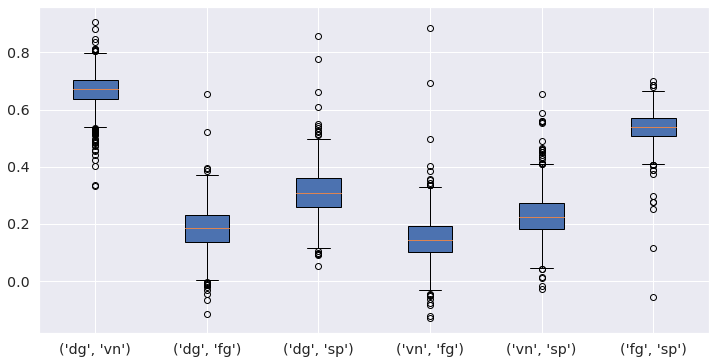

In [66]:
plot_corr_boxplots(df_wk)

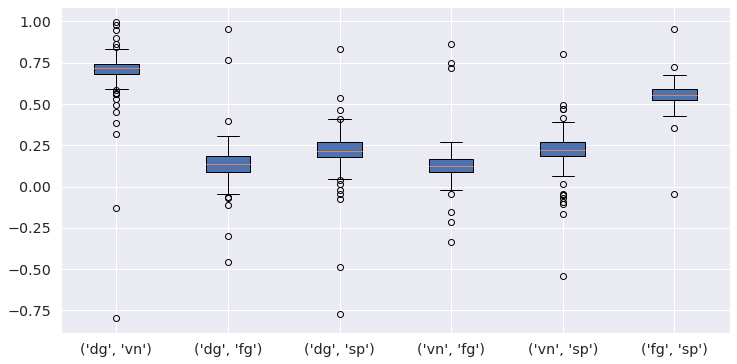

In [67]:
plot_corr_boxplots(df_tp)

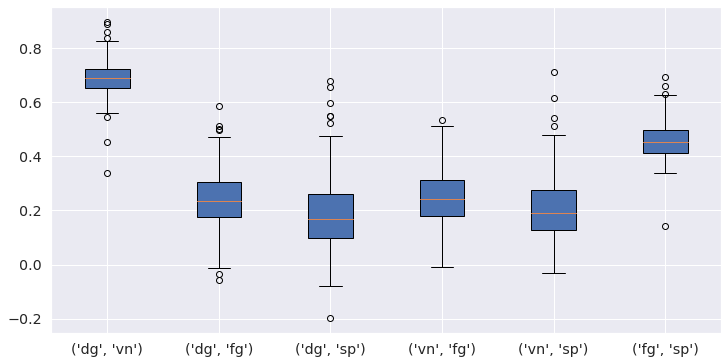

In [68]:
plot_corr_boxplots(df_ff)

# Scenes

In [20]:
wk_data = pd.read_csv('../videos_data/diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
tp_data = pd.read_csv('../videos_data/present/The Present_Short-Scenes.csv', header = 1)
ff_data = pd.read_csv('../videos_data/fractals/Fun_Fractals_v2-Scenes.csv', header = 1)

In [21]:
def calc_scenes(df, df_scenes):
    scenes_list = []
    for idx, row in df.iterrows():
        scene_idx = np.where((row.FRAME_idx >= df_scenes['Start Frame']) & (row.FRAME_idx < df_scenes['End Frame']))
        scenes_list.append(df_scenes.iloc[scene_idx]['Scene Number'])
    return scenes_list

In [22]:
scenes_tp = calc_scenes(df_tp, tp_data)
scenes_wk = calc_scenes(df_wk, wk_data)
scenes_ff = calc_scenes(df_ff, ff_data)

In [23]:
scenes_tp = list(map(lambda x: x.values[0], scenes_tp))
scenes_wk = list(map(lambda x: x.values[0], scenes_wk))
scenes_ff = list(map(lambda x: x.values[0], scenes_ff))

In [24]:
df_wk['Scenes'] = scenes_wk
df_tp['Scenes'] = scenes_tp
df_ff['Scenes'] = scenes_ff

In [25]:
df_wk.columns

Index(['ID', 'FIX_idx', 'NSS_dg', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
       'FRAME_idx', 'NSS_vn', 'NSS_fg', 'NSS_sp', 'x_mean', 'y_mean',
       'start_time', 'Scenes'],
      dtype='object')

## Reaload dfs

Only if needed in case to avoid reerun everything up to this point

In [27]:
loading_path = os.path.join('..', 'results', 'full_sabine')

In [28]:
df_wk2 = pd.read_csv(os.path.join(loading_path, 'results_nss_wk_full.csv'))

## Calculations

In [26]:
df_wk.groupby(['ID', 'Scenes'])[saliency_models_nss].mean().unstack(level=0).head()

NSS_dg                                                      \
ID     NDARAA075AMK NDARAA117NEJ NDARAA948VFH NDARAC349YUC NDARAC350XUM   
Scenes                                                                    
1          1.097726     1.037964     1.378386     1.127329     0.482119   
2          1.391617     0.445252     1.431405     1.093518          NaN   
3          0.331094     1.289026     1.655309     1.179105          NaN   
4          1.723844     0.425321     1.176409     1.321408          NaN   
5          2.349400     0.533069     2.677721     1.478582          NaN   

                                                                         ...  \
ID     NDARAC853DTE NDARAC904DMU NDARAD481FXF NDARAD774HAZ NDARAE012DGA  ...   
Scenes                                                                   ...   
1         -0.337040     2.274569     1.133934     1.516540     1.697699  ...   
2         -0.077192     2.783401     0.890490     2.477942     1.096856  ...   
3          1.521194     1.514500     0.875381     1.036723     1.071927  ...   
4          0.559340     0.655556     1.276918     1.697053     1.335259  ...   
5          0.456748     1.682983     1.509835     0.729283     1.117308  ...   

             NSS_sp                                                      \
ID     NDARZR412TBP NDARZT772PU4 NDARZU822WN3 NDARZV766YXP NDARZV895RZ5   
Scenes                                                                    
1          0.830724     0.963719     1.264310     1.643036     0.583555   
2         -0.049490    -0.049490    -0.049490    -0.232861    -0.049490   
3         -0.322078    -0.542641    -0.696002     0.143120    -0.378199   
4          0.218568    -0.275307    -0.513473     0.292762    -0.325194   
5         -0.126863    -0.248657    -0.595054     0.060426    -0.242644   

                                                                         
ID     NDARZW013RUH NDARZW873DN3 NDARZX561DR9 NDARZY101JNB NDARZZ007YMP  
Scenes                                                                   
1         -0.324392     0.402424     1.627709     0.665347     0.185039  
2               NaN          NaN     0.598222          NaN    -0.049490  
3               NaN          NaN    -0.666615          NaN    -0.410334  
4               NaN          NaN    -0.065873    -0.573989    -0.265323  
5               NaN          NaN    -0.590822    -0.480077    -0.246011  

[5 rows x 3620 columns]

In [27]:
def calculate_nss_scenes(df, scenes_data, saliency_models = saliency_models_nss):
    nss_scenes = []
    nss_scenes_err = []
    for sal in saliency_models_nss:
        nss_scenes.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].mean(axis=1))
        nss_scenes_err.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].sem(axis=1))

    nss_scenes = pd.DataFrame(nss_scenes).T
    nss_scenes.columns = saliency_models
    nss_scenes_err = pd.DataFrame(nss_scenes_err).T
    nss_scenes_err.columns = saliency_models
    
    
    time_index = (pd.to_timedelta(scenes_data['Start Timecode']) + pd.to_timedelta(scenes_data['Length (timecode)'])/2).dt.total_seconds()
    time_index.name = 'scene_time'
    nss_scenes_toplot = nss_scenes.reset_index(drop=True)
    
    nss_scenes_toplot = nss_scenes_toplot.join(time_index).set_index('scene_time')
    nss_scenes_toplot_err = nss_scenes_err.reset_index(drop=True).join(time_index).set_index('scene_time')
    
    fig, ax = plt.subplots(figsize=(18,7))
    nss_scenes_toplot.plot(ax=ax, yerr=nss_scenes_toplot_err)
    ax.set_xlabel('Time (s)')
    
    a = pd.melt(nss_scenes.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    b = pd.melt(nss_scenes_err.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    return pd.merge(a,b, left_on=['Scenes','saliency_type'], right_on=['Scenes','saliency_type'], how = 'outer', suffixes=('','_err'))

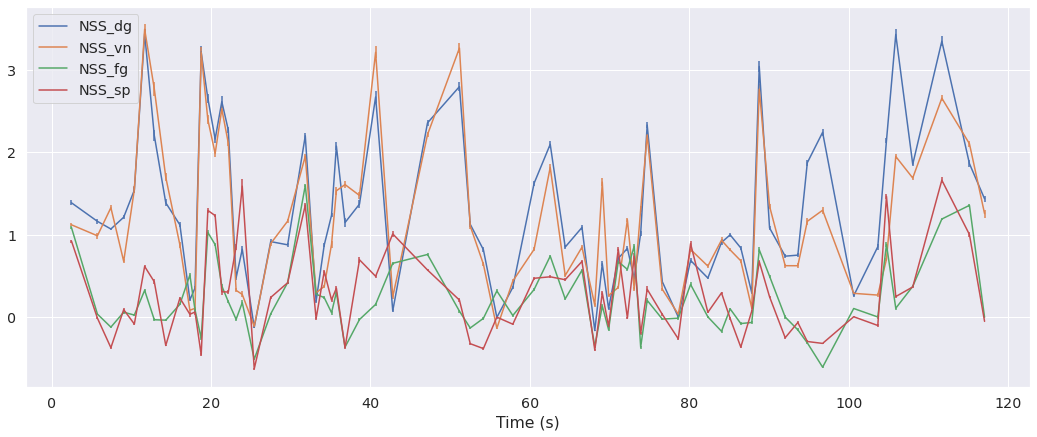

In [34]:
_ = calculate_nss_scenes(df_wk, scenes_data=wk_data)

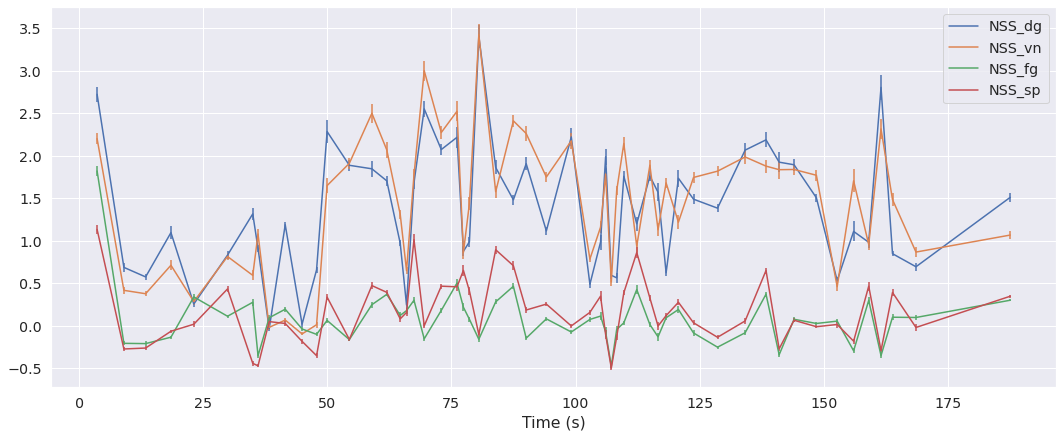

In [76]:
_ = calculate_nss_scenes(df_tp, tp_data)

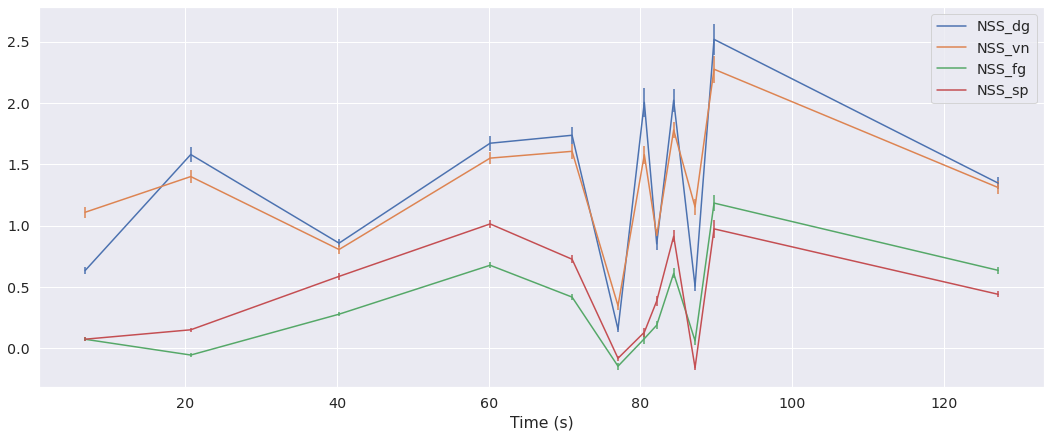

In [77]:
_ = calculate_nss_scenes(df_ff, ff_data)

## Correlations with scene length
Ojo que en los df hay nans!!

In [28]:
from scipy.stats import pearsonr

In [29]:
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    dfcorr = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            dfcorr[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return dfcorr, pvalues

In [80]:
def calculate_scenes_corrs(df, scenes_data, saliency_models, do_plot=True):
    mean_nss = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].mean().unstack(level=0)[sal]
        scenes_nss = scenes_nss.mean(axis=1)
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    nss_vals_scenes = pd.concat(mean_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    
    ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        #fig, ax = plt.subplots(figsize=(10,7))
        #sns.scatterplot(x = 'Length (seconds)', y ='NSS', hue='saliency', data= ret, ax=ax, palette=palette)
        sns.lmplot(x = 'Length (seconds)', y ='NSS', hue='saliency', data= ret, palette=palette, height=7)
        
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[:-1,-1], corrs[1].iloc[:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out

In [81]:
calculate_scenes_corrs(df_wk, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.0404,0.7397
NSS_vn,0.0362,0.7663
NSS_fg,0.2456,0.0404
NSS_sp,0.1436,0.2358


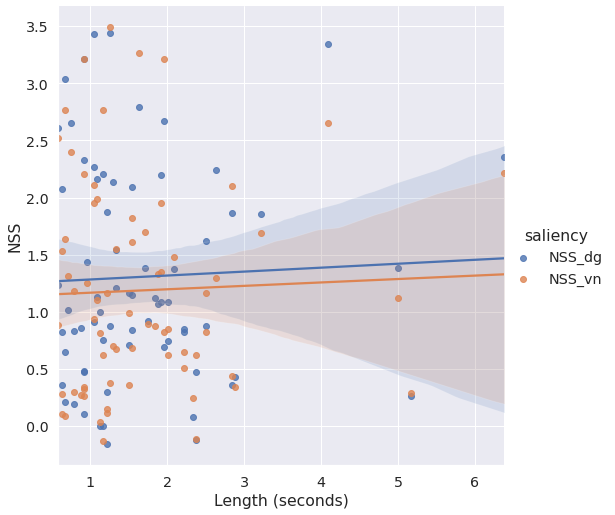

In [82]:
_ = calculate_scenes_corrs(df_wk, wk_data, ['NSS_dg', 'NSS_vn'])

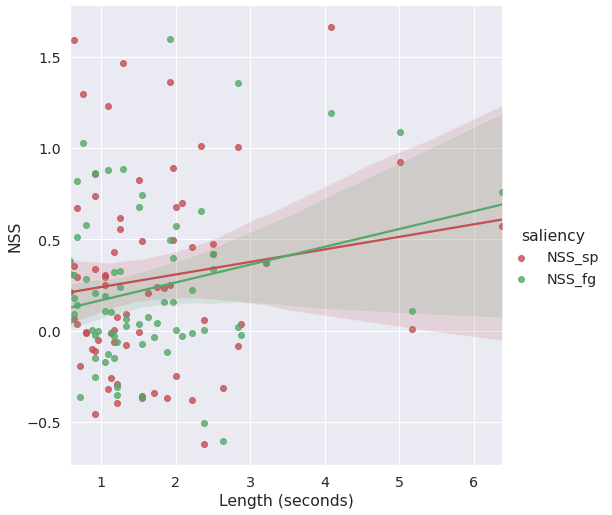

In [83]:
_ = calculate_scenes_corrs(df_wk, wk_data, ['NSS_sp', 'NSS_fg'])

In [84]:
calculate_scenes_corrs(df_tp, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.0314,0.8202
NSS_vn,-0.0689,0.6172
NSS_fg,0.1791,0.1908
NSS_sp,0.1235,0.3691


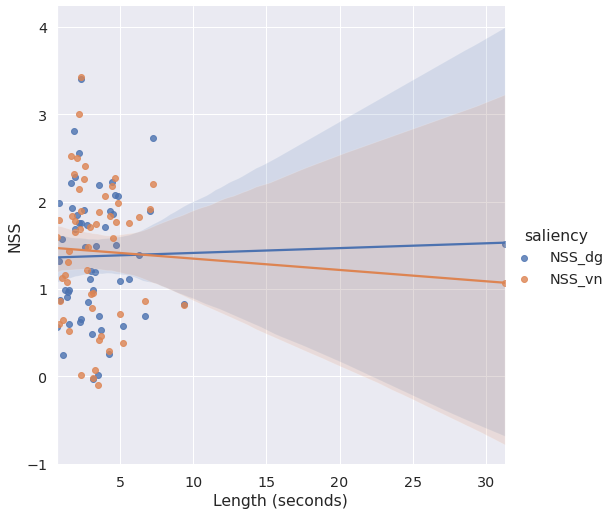

In [85]:
_ = calculate_scenes_corrs(df_tp, tp_data, ['NSS_dg', 'NSS_vn'])

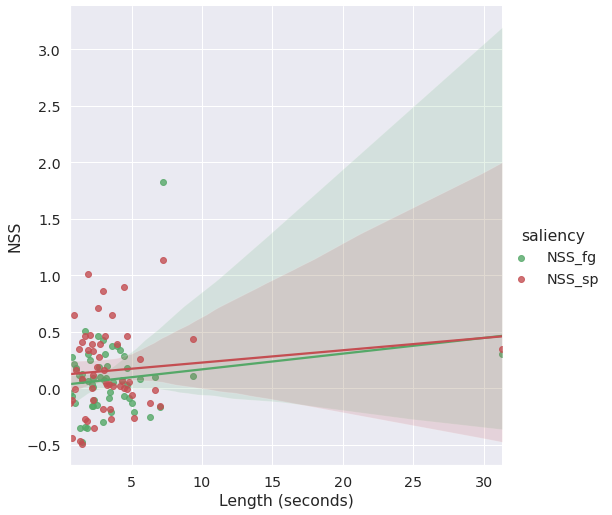

In [86]:
_ = calculate_scenes_corrs(df_tp, tp_data, ['NSS_fg', 'NSS_sp'])

In [87]:
calculate_scenes_corrs(df_ff, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,-0.0771,0.8117
NSS_vn,-0.116,0.7196
NSS_fg,0.184,0.567
NSS_sp,0.0423,0.8961


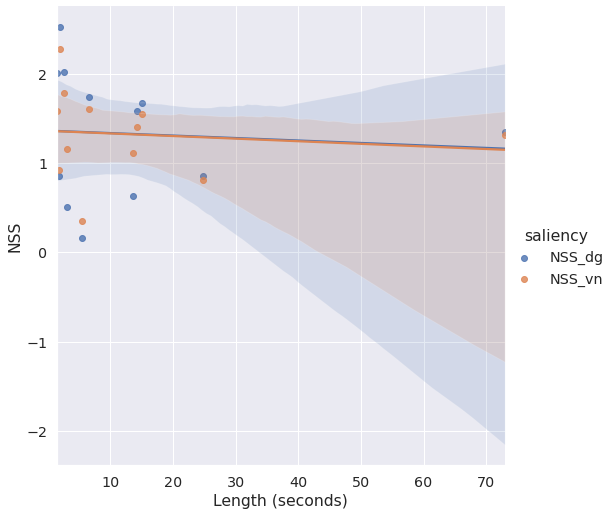

In [88]:
_ = calculate_scenes_corrs(df_ff, ff_data, ['NSS_dg', 'NSS_vn'])

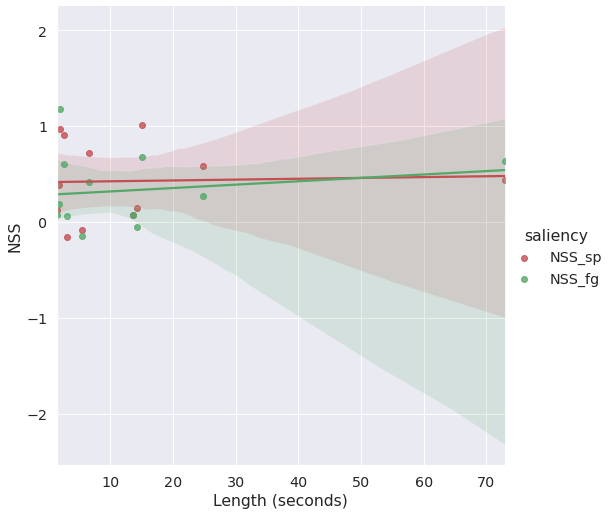

In [89]:
_ = calculate_scenes_corrs(df_ff, ff_data, ['NSS_sp', 'NSS_fg'])

### Dispersion acording scene length

In [76]:
def calculate_scenes_mean_dispersion(df, scenes_data, saliency_models, do_plot=True):
    mean_std_nss = []
    std_std_nss  = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].std().unstack(level=0)[sal]
        # mean value of fixations for each scene for each subject
        scenes_nss_mean_std = scenes_nss.mean(axis=1)
        scenes_nss_std_std  = scenes_nss.std(axis=1)
        scenes_nss_mean_std.name = sal
        mean_std_nss.append(scenes_nss_mean_std)
        scenes_nss_std_std.name = sal
        std_std_nss.append(scenes_nss_mean_std)
        
    nss_vals_scenes = pd.concat(mean_std_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
#     nss_vals_scenes = nss_vals_scenes.join(pd.concat(std_std_nss,axis=1), rsuffix = '_std')#[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    nss_vals_scenes.reset_index(inplace=True)
    
    ret = pd.melt(nss_vals_scenes, 
                  value_vars = saliency_models,
                  id_vars = ['Scenes', 'Length (seconds)'], 
                  var_name = 'saliency',
                  value_name = 'NSS_std')
    
#     ret = pd.melt(ret, 
#                   value_vars = [s + '_std' for s in saliency_models],
#                   id_vars = ['Scenes','Length (seconds)','saliency', 'NSS_std'], 
#                   var_name = 'saliency_std',
#                   value_name = 'NSS_disp')

    #     ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        #fig, ax = plt.subplots(figsize=(10,7))
        #sns.scatterplot(x = 'Length (seconds)', y ='NSS_std', hue='saliency', data= ret, ax=ax, palette=palette)
        sns.lmplot(x = 'Length (seconds)', y ='NSS_std', hue='saliency', data= ret, palette=palette, height=7)
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[1:-1,-1], corrs[1].iloc[1:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out
#     return ret

In [77]:
calculate_scenes_mean_dispersion(df_wk, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.3163,0.0076
NSS_vn,0.2582,0.0309
NSS_fg,0.4336,0.0002
NSS_sp,0.3148,0.008


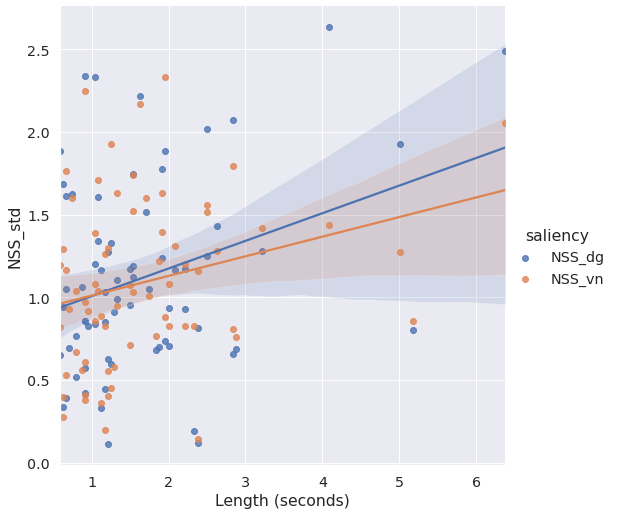

In [78]:
_ = calculate_scenes_mean_dispersion(df_wk, wk_data, ['NSS_dg', 'NSS_vn'])

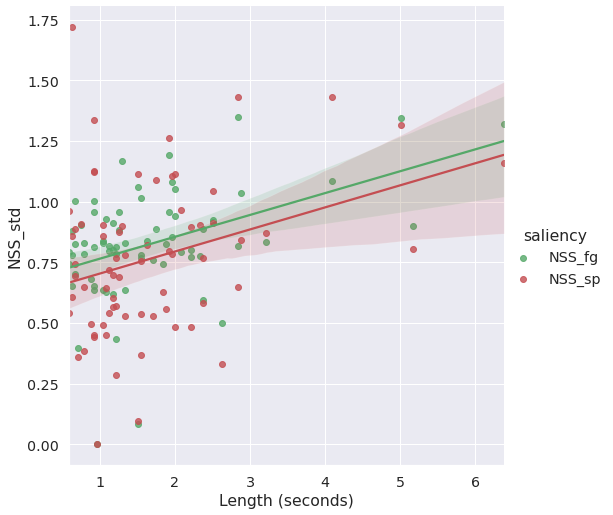

In [79]:
_ = calculate_scenes_mean_dispersion(df_wk, wk_data, ['NSS_fg', 'NSS_sp'])

In [95]:
calculate_scenes_mean_dispersion(df_tp, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.3272,0.0147
NSS_vn,0.3796,0.0043
NSS_fg,0.2768,0.0408
NSS_sp,0.2129,0.1186


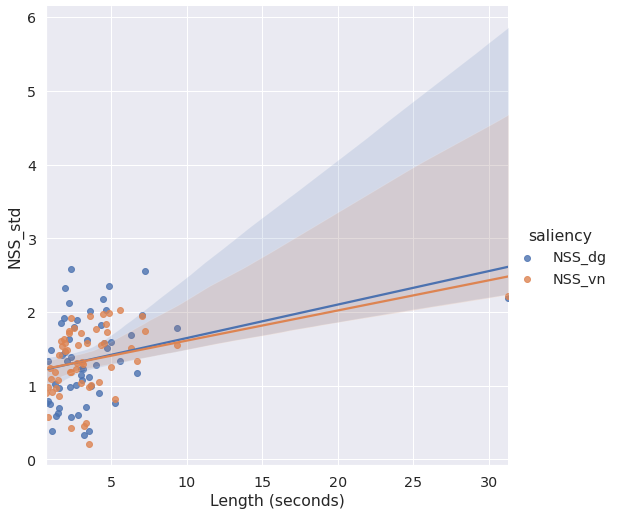

In [90]:
_ = calculate_scenes_mean_dispersion(df_tp, tp_data, ['NSS_dg', 'NSS_vn'])

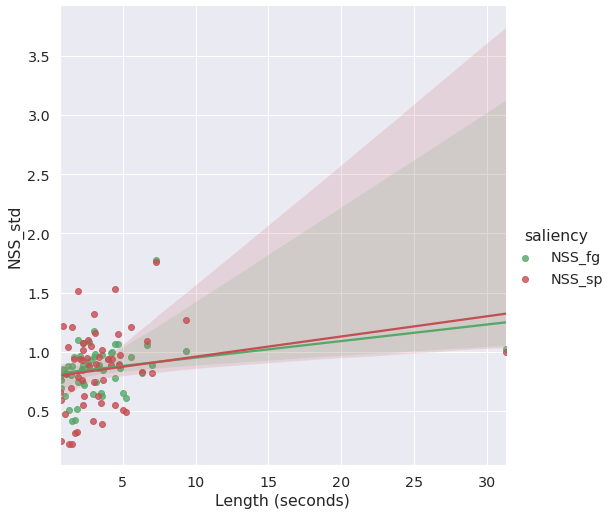

In [91]:
_ = calculate_scenes_mean_dispersion(df_tp, tp_data, ['NSS_fg', 'NSS_sp'])

In [92]:
calculate_scenes_mean_dispersion(df_ff, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.2329,0.4664
NSS_vn,0.4326,0.1601
NSS_fg,-0.0715,0.8252
NSS_sp,0.383,0.2191


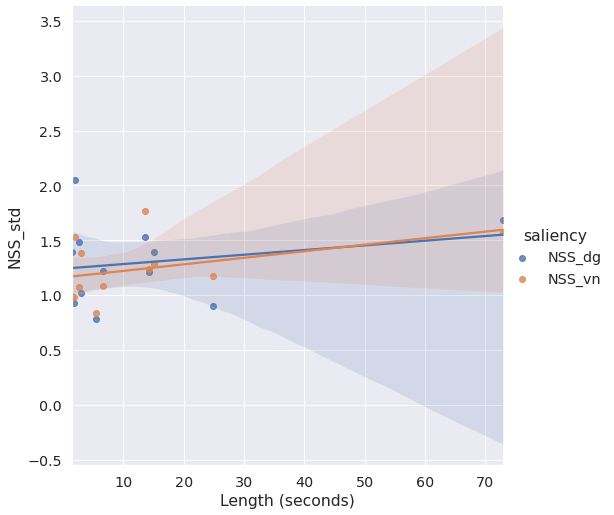

In [93]:
_ = calculate_scenes_mean_dispersion(df_ff, ff_data, ['NSS_dg', 'NSS_vn'])

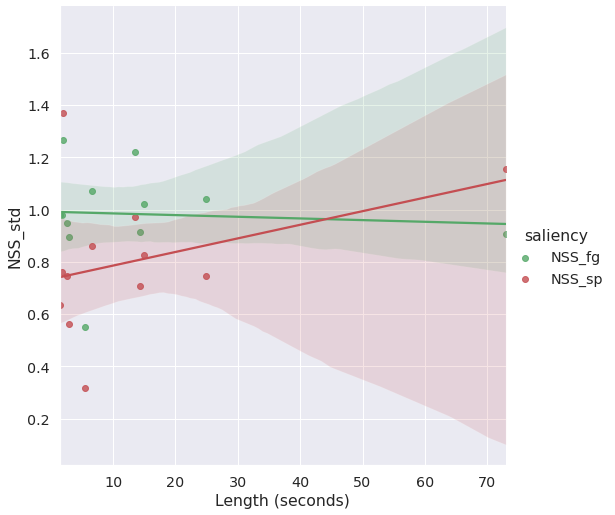

In [94]:
_ = calculate_scenes_mean_dispersion(df_ff, ff_data, ['NSS_fg', 'NSS_sp'])

## Scenes entropy

### Entropy cals - RUN ONLY ONCE

In [32]:
from skimage.filters.rank import entropy
from skimage.io import imread
from skimage.morphology import disk
import json

In [33]:
saliency_path = '../videos_sal/'
saliency_fold = 'deepgazeii'

In [476]:
entropy_vals = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        img= imread(os.path.join(path,img_file), as_gray=True)
        entropy_vals[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

In [481]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals, fp)

In [484]:
saliency_fold = 'vinet'
entropy_vals_vn = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_vn[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/vinet/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [485]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_vn, fp)

In [486]:
saliency_fold = 'finegrained'
entropy_vals_fg = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_fg[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/finegrained/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [487]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_fg, fp)

### Load entropy

In [34]:
saliency_path = '../videos_sal/'

In [35]:
saliency_fold = 'deepgazeii'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    dg_entropy = json.load(json_file)

saliency_fold = 'finegrained'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    fg_entropy = json.load(json_file)

saliency_fold = 'spectral'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    sp_entropy = json.load(json_file)

saliency_fold = 'vinet'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    vn_entropy = json.load(json_file)

In [36]:
sal_dict = dict(zip(saliency_models_nss,[dg_entropy, vn_entropy, fg_entropy, sp_entropy]))

ent = []
for vid in videos_data.iloc[:3,0].index:
    ent_vid = []
    for sal in sal_dict.keys():
        sal_vid_ent = sal_dict[sal][vid]
        ent_vid.append(sal_vid_ent)
    df = pd.DataFrame(ent_vid).T
    df.columns = saliency_models_nss
    ent.append(df)
ent = dict(zip(videos_data.iloc[:3,0].index, ent))

In [37]:
scene_vid = dict(zip(videos_data.iloc[:3,0].index,[wk_data,ff_data,tp_data]))
for vid in scene_vid.keys():
    ent[vid]['FRAME_idx'] = ent[vid].index
    aux = calc_scenes(ent[vid], scene_vid[vid])
    aux = pd.DataFrame([a.values for a in aux], columns = ['Scenes']).fillna(scene_vid[vid]['Scene Number'].iloc[-1])
    aux['Scenes'] = aux['Scenes'].astype(int)
    ent[vid] = ent[vid].join(aux)#.drop(columns=['FRAME_idx'])
    ent[vid] = ent[vid].groupby('Scenes').mean()

### Correlation NSS with entropy per scene

In [145]:
dg_entropy['Present'][500]

0.5267457415058924

In [148]:
vn_entropy['Present'][500]

0.4649167053942976

In [147]:
sp_entropy['Present'][500]

1.2527462321725449

In [149]:
fg_entropy['Present'][500]

3.2436439612989205

In [61]:
def calculate_scenes_corrs_entropy(df, df_entropy, scenes_data, saliency_models,var='mean'):
    mean_nss = []
    n = len(saliency_models)
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal]
        if var=='mean':
            scenes_nss = scenes_nss.mean(axis=1)
        elif var=='dispersion':
            scenes_nss = scenes_nss.std(axis=1)
        else:
            print('No valid var type')
            return None
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    df_nss = pd.DataFrame(mean_nss).T
    df = df_nss.join(df_entropy, rsuffix='_ent')
    fig, ax = plt.subplots(1,n,figsize=(22,7))
    
    for i, sal in enumerate(saliency_models):
        sns.regplot(x = sal+'_ent', y = sal, data = df, ax = ax[i])
        ax[i].set_ylabel('')
        ax[i].set_xlabel(sal[4:]+'_ent')
    if var=='mean':
        ax[0].set_ylabel('NSS_mean')
    else:
        ax[0].set_ylabel('NSS_std')
        
    return df.corr().iloc[:n,n:]

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,0.005364,0.230598,-0.180816,-0.208860,-0.029632
NSS_vn,-0.056649,0.191723,-0.175426,-0.187725,-0.136670
NSS_fg,-0.221534,0.107834,-0.361006,-0.428996,0.018756
NSS_sp,-0.295332,-0.109343,-0.319916,-0.407864,-0.027766


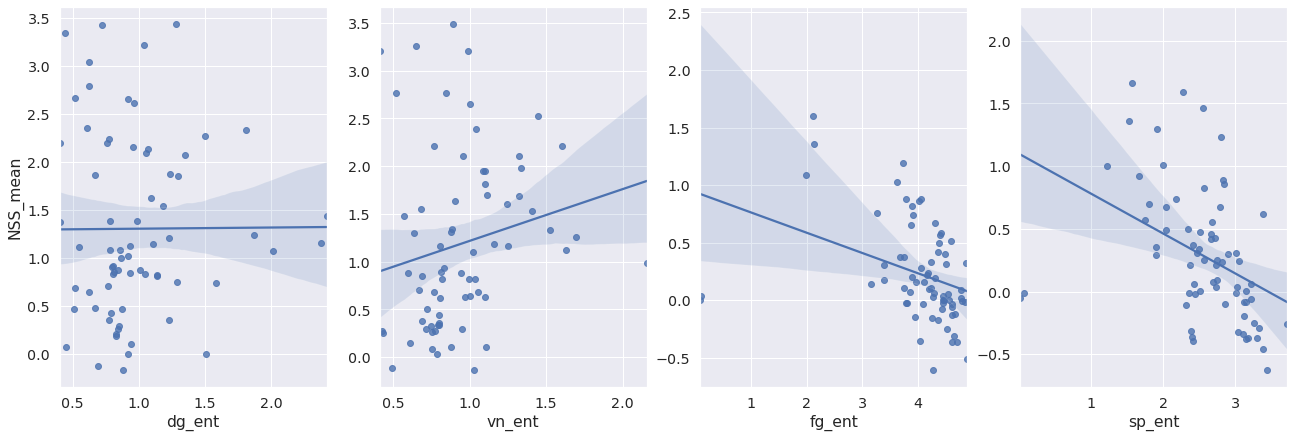

In [62]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss)

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.314803,-0.140379,-0.257928,-0.247575,0.142744
NSS_vn,-0.247675,0.115748,-0.151552,-0.053558,0.251206
NSS_fg,-0.108825,0.022230,-0.307651,-0.165493,-0.210075
NSS_sp,-0.318599,-0.071841,-0.119182,-0.086229,0.010192


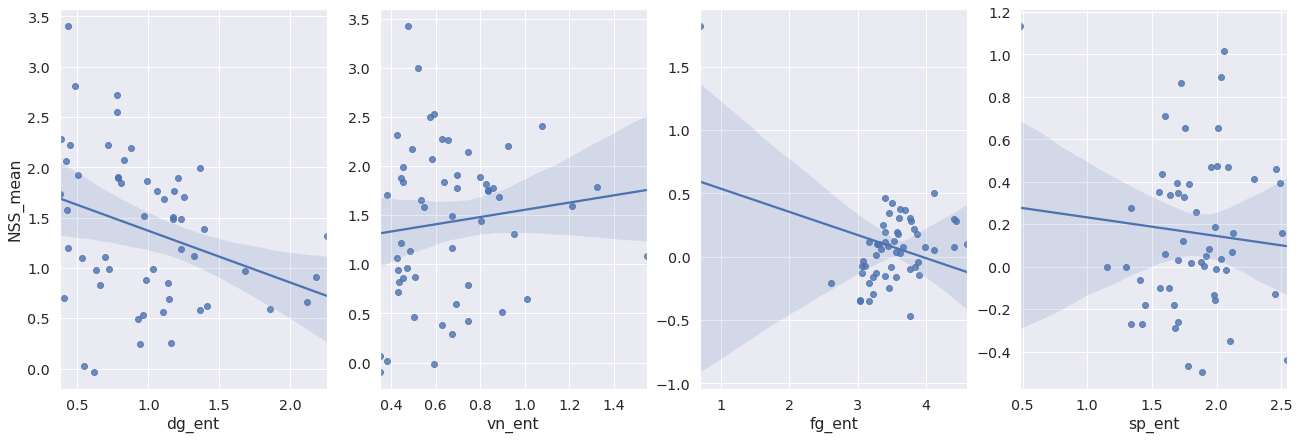

In [64]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss)

### Correlation NSS dispersion with entropy per scene

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.175919,0.105112,-0.158924,-0.192304,-0.058327
NSS_vn,-0.047614,0.027440,-0.132010,-0.138007,-0.223275
NSS_fg,-0.280669,-0.227884,0.233742,0.160875,-0.110460
NSS_sp,-0.258064,-0.259681,-0.008341,-0.075978,-0.200690


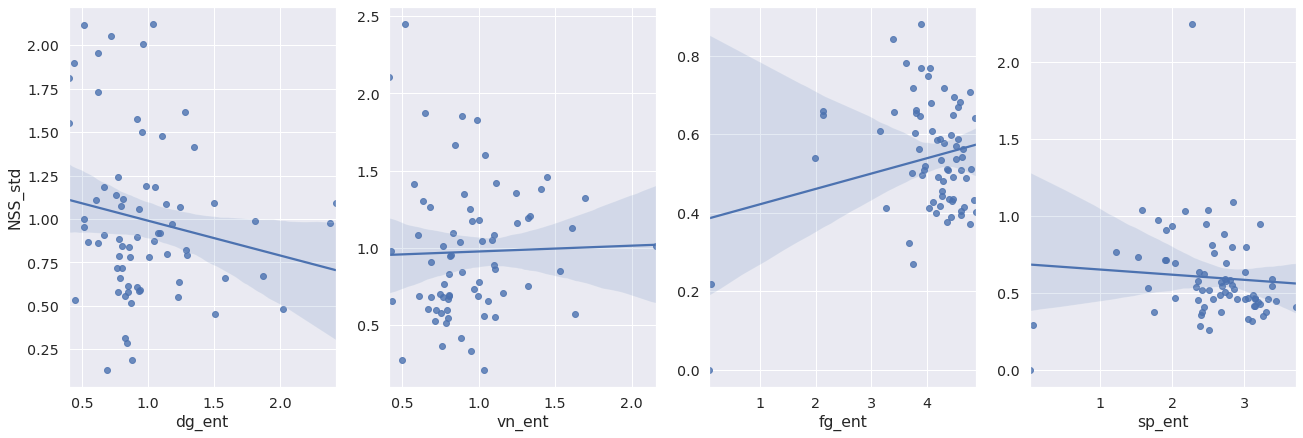

In [65]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss, var='dispersion')

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.558916,-0.293078,-0.217054,-0.316573,0.184599
NSS_vn,-0.415024,-0.200881,-0.074052,-0.093893,0.317635
NSS_fg,-0.092379,0.216733,-0.172284,-0.124721,-0.061794
NSS_sp,-0.277948,0.030544,0.032808,0.027911,0.018542


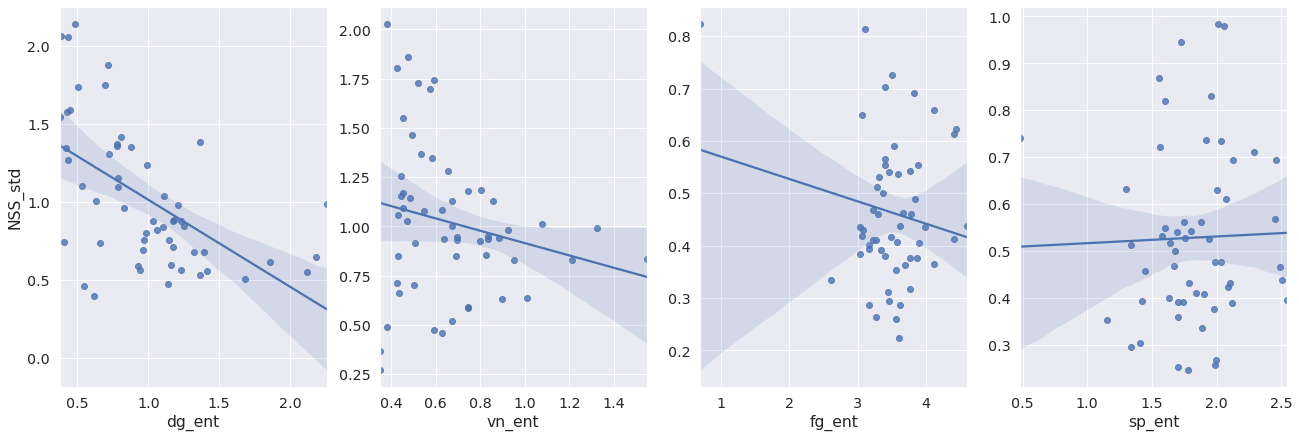

In [66]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss, var='dispersion')

## Other features - Faces